In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorboard.backend.event_processing import event_accumulator
from pathlib import Path
import matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np, os
import matplotlib.ticker as mticker   

In [3]:
print("This is a test")

This is a test


In [4]:
%matplotlib inline

In [7]:
#run_dir = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/scratch_training/4in_registry_processed/0x53D7/seed_1"

#run_dir = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript_v2/scratch_training/4in/0x000D/seed_1"

#run_dir = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript_v2/trained_agents/GAT_MLP_with_scalars_4000_logic_functions"

run_dir =  "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript_v2/trained_agents/GAT_MLP_with_scalars_4000_logic_functions"

#No learn control
#run_dir = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/trained_agents/controls/GAT_MLP_with_scalars_4000_logic_functions_no_learn_control"


10.117881774902344

<Figure size 800x400 with 0 Axes>

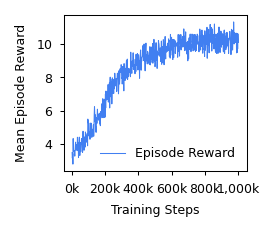

In [8]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# GraphPad-style Matplotlib settings
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
    "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
    "pdf.use14corefonts": False,  # allow embedding non-core fonts
    "svg.fonttype": "none",       # keep SVG text as text (not paths)
})

pt_to_in = lambda pt: pt / 72
fig = plt.figure()    

# Load TensorBoard data
event_path = run_dir
ea = event_accumulator.EventAccumulator(event_path)
ea.Reload()

reward_events = ea.Scalars('rollout/ep_rew_mean')
steps = [e.step for e in reward_events]
values = [e.value for e in reward_events]

# Smooth values (optional)
#smoothed_values = smooth(values, weight=0.0)

# Plot
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)   
ax.plot(steps, values, label="Episode Reward", color='#417FF1')

# GraphPad style aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.xaxis.set_major_locator(mticker.MultipleLocator(200_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)
    
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)
#ax.tick_params(axis='both', which='both', direction='out')
ax.legend(loc='best')

ax.set_xlabel("Training Steps")
ax.set_ylabel("Mean Episode Reward")
#ax.set_xlim(left = 1600, right = 3200)
#ax.set_ylim((3.1, 10.9))
#ax.yaxis.set_major_locator(mticker.MultipleLocator(4))
#ax.set_title("Agent Performance Over Time")

plt.tight_layout()
plt.savefig(Path(run_dir) / "training_reward_graphpad_style.svg", format = 'svg')  # Optional: "training_reward_graphpad_style.png", dpi=300
#plt.show()

values[-1]

Time elapsed

In [9]:
times = [e.wall_time for e in reward_events]
training_time = times[-1] - times[0]

hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)
seconds = int(training_time % 60)

print(f"Time elapsed is {hours}h {minutes}m {seconds}s")

Time elapsed is 16h 52m 3s


In [10]:
steps = [e.step for e in reward_events]
steps_so_far = steps[-1] 

print(f"{steps_so_far} steps so far")

1000000 steps so far


Mean circuit size

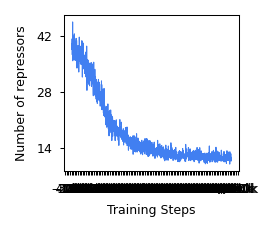

7.000000066757202

In [11]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import numpy as np
import re
from collections import defaultdict

# GraphPad-style Matplotlib settings
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
    "ps.fonttype": 42,            # same for EPS
    "pdf.use14corefonts": False,  # allow embedding non-core fonts
    "svg.fonttype": "none",       # keep SVG text as text (not paths)
})
pt_to_in = lambda pt: pt / 72

# --- Load TensorBoard scalars ---
ea = event_accumulator.EventAccumulator(run_dir, size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()
scalar_tags = set(ea.Tags().get("scalars", []))

# Collect per-env episode returns grouped by dump step
env_tag_re = re.compile(r"^env\d+/episode_return$")
env_tags = [t for t in scalar_tags if env_tag_re.match(t)]
if not env_tags:
    raise RuntimeError("No 'env*/episode_return' tags found in this run.")

step_to_returns = defaultdict(list)
for tag in env_tags:
    for ev in ea.Scalars(tag):
        step_to_returns[ev.step].append(ev.value)

energy_steps = sorted(step_to_returns.keys())
mean_energy = []
for s in energy_steps:
    returns = np.asarray(step_to_returns[s], dtype=float)
    valid = returns > 0.0               # ignore non-positive returns to avoid 100/0 or negatives
    if not np.any(valid):
        mean_energy.append(np.nan)
        continue
    energies = 100.0 / returns[valid]   # energy_i = 100 / return_i
    mean_energy.append(float(np.mean(energies)))


# Plot only mean energy 
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)
ax.plot(energy_steps, mean_energy, color='#417FF1', label="Arithmetic Mean Energy")

# GraphPad aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.xaxis.set_major_locator(mticker.MultipleLocator(10_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

#ax.set_ylim((5, 64))
ax.yaxis.set_major_locator(mticker.MultipleLocator(14))

ax.set_xlabel("Training Steps")
ax.set_ylabel("Number of repressors")

plt.tight_layout()
plt.savefig(Path(run_dir) /"training_arithmetic_mean_energy_graphpad_style.svg", format='svg', dpi = 300)
plt.show()

energies[-1]


Harmonic mean energy

<Figure size 800x400 with 0 Axes>

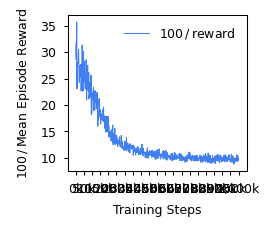

In [12]:
# Load TensorBoard scalar just as before

pt_to_in = lambda pt: pt / 72
fig = plt.figure()    

event_path = run_dir
ea = event_accumulator.EventAccumulator(event_path)
ea.Reload()

reward_events = ea.Scalars('rollout/ep_rew_mean')
steps  = np.asarray([e.step  for e in reward_events], dtype=float)
values = np.asarray([e.value for e in reward_events], dtype=float)

# Transform: 100 / reward  (handle zeros safely)
                               # avoid /0
inv_values = 100.0 / values

# Plot
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)   # 80 pt × 80 pt
ax.plot(steps, inv_values,
        label=r"$100 \,/\, \mathrm{reward}$",
        color='#417FF1',
        linewidth=0.5)

# GraphPad aesthetics (same as before)
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

ax.xaxis.set_major_locator(mticker.MultipleLocator(50_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
    
ax.tick_params(axis='both', which='both',
               direction='out', length=2, width=0.5)
#ax.tick_params(axis='both', which='both', direction='out')
ax.legend(loc='best')

ax.set_xlabel("Training Steps")
ax.set_ylabel(r"$100 \,/\, \mathrm{Mean\ Episode\ Reward}$")
#ax.set_xlim(left=0, right=110_000)

plt.tight_layout()
#plt.savefig(Path(run_dir) /"training_inv_reward_graphpad_style.svg", format='svg', dpi = 300)
# plt.show()


Per episode plot

/tmp/ipykernel_3706818/3954908303.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  COLORS = cm.get_cmap("Blues")(np.linspace(0.25, 0.85, n))


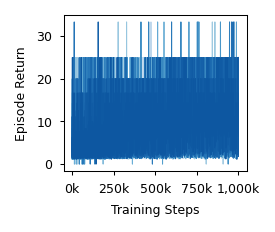

In [13]:
# ------
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import re, numpy as np

# GraphPad-style Matplotlib settings
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
    "ps.fonttype": 42,            # same for EPS
    "pdf.use14corefonts": False,  # allow embedding non-core fonts
    "svg.fonttype": "none",       # keep SVG text as text (not paths)
})
pt_to_in = lambda pt: pt / 72

# ---------------- optional exponential-moving-average ------------------------
def smooth(y, weight=0.0):
    """Simple EMA smoother; set weight→0 for no smoothing."""
    if not y:
        return y
    out, last = [], y[0]
    for v in y:
        last = weight * last + (1 - weight) * v
        out.append(last)
    return out

# ---------------- load the event file(s) ------------------------------------
ea = event_accumulator.EventAccumulator(str(run_dir), size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()

# ---------------- discover all envN tags automatically ----------------------
all_scalar_tags = ea.Tags().get('scalars', [])
env_tags = [t for t in all_scalar_tags if re.fullmatch(r'env\d+/episode_return', t)]
if not env_tags:
    raise RuntimeError("No 'env*/episode_return' scalars found — did you enable PerEnvReturnAndLogCallback?")

# ---------------- plot -------------------------------------------------------
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)

n = len(env_tags)
COLORS = cm.get_cmap("Blues")(np.linspace(0.25, 0.85, n))

for tag, c in zip(sorted(env_tags), COLORS):
    scalars = ea.Scalars(tag)
    x = [e.step for e in scalars]
    y = smooth([e.value for e in scalars], weight=0.0)  # set weight>0 for EMA
    ax.plot(x, y, label=tag.split('/')[0], color=c)

# GraphPad aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

#ax.set_xlim(left=960000, right=1_000_000)
#ax.set_xlim(left=0, right=40000)
ax.set_xlabel("Training Steps")
ax.set_ylabel("Episode Return")

ax.xaxis.set_major_locator(mticker.MultipleLocator(250_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))

ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)
# ax.legend(title="Environment", ncol=2)  # optional; can be cluttered with many envs

plt.tight_layout()
plt.show()


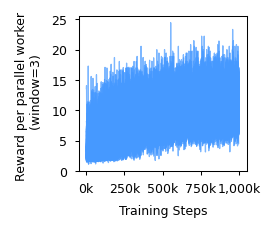

In [14]:
# --- Moving-window mean of per-env episode returns, single color ---
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import numpy as np
import re


# GraphPad-style Matplotlib settings
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "pdf.use14corefonts": False,
    "svg.fonttype": "none",
})
pt_to_in = lambda pt: pt / 72

def moving_average(y, window):
    """Episode-based moving average aligned to the right (last point uses last 'window' episodes)."""
    if len(y) < window:
        return np.array([])  # not enough points
    k = np.ones(window, dtype=float) / window
    return np.convolve(np.asarray(y, dtype=float), k, mode="valid")

# --- Load TB scalars ---
ea = event_accumulator.EventAccumulator(run_dir, size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()
scalar_tags = set(ea.Tags().get("scalars", []))

env_tags = sorted(t for t in scalar_tags if re.fullmatch(r"env\d+/episode_return", t))
if not env_tags:
    raise RuntimeError("No 'env*/episode_return' tags found — did you enable PerEnvReturnAndLogCallback?")

# Parameters
WINDOW = 3                # moving window size (episodes)
COLOR  = "#4699FF"           # single color for all lines
ALPHA  = 0.7                 # transparency (0=transparent, 1=opaque)

# --- Plot ---
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)

for tag in env_tags:
    evs = ea.Scalars(tag)
    x = [e.step for e in evs]          # step where the episode finished
    y = [e.value for e in evs]         # episode return
    y_ma = moving_average(y, WINDOW)
    if y_ma.size == 0:
        continue
    x_ma = np.asarray(x, dtype=int)[WINDOW-1:]  # right-aligned with window end
    ax.plot(x_ma, y_ma, color=COLOR, alpha=ALPHA, linewidth=0.6)

# GraphPad aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.xaxis.set_major_locator(mticker.MultipleLocator(250_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

ax.set_xlabel("Training Steps")
ax.set_ylabel(f"Reward per parallel worker \n (window={WINDOW})")

plt.tight_layout()
plt.show()


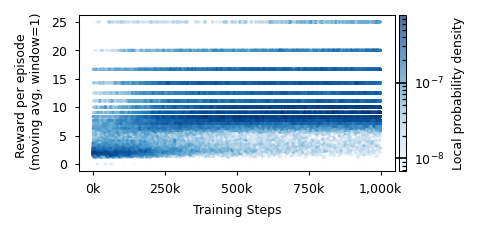

In [15]:
# --- Scatter of per-episode REWARD with local probability density coloring ---
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import numpy as np
import re

# <<< set this to your TensorBoard run directory >>>
# run_dir = "/path/to/output_folder_name"

# GraphPad-style Matplotlib settings
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "pdf.use14corefonts": False,
    "svg.fonttype": "none",
})
pt_to_in = lambda pt: pt / 72

def moving_average(y, window):
    """Episode-based moving average aligned to the right (last point uses last 'window' episodes)."""
    if window <= 1:
        return np.asarray(y, dtype=float)
    if len(y) < window:
        return np.array([])  # not enough points
    k = np.ones(window, dtype=float) / window
    return np.convolve(np.asarray(y, dtype=float), k, mode="valid")

# --- Load TB scalars ---
ea = event_accumulator.EventAccumulator(run_dir, size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()
scalar_tags = set(ea.Tags().get("scalars", []))

env_tags = sorted(t for t in scalar_tags if re.fullmatch(r"env\d+/episode_return", t))
if not env_tags:
    raise RuntimeError("No 'env*/episode_return' tags found — did you enable PerEnvReturnAndLogCallback?")

# Parameters
WINDOW     = 1                # moving window size over episodes (1 = raw episodes)
MAX_POINTS = 250_000          # downsample cap for plotting performance
BINS_XY    = (150, 150)       # bins for 2D density estimation (x,y)
DOT_SIZE   = 2.0              # scatter marker size
ALPHA      = 0.7              # scatter transparency

# --- Aggregate all (step, reward) pairs across envs ---
all_steps = []
all_rewards = []

for tag in env_tags:
    evs = ea.Scalars(tag)
    steps = np.asarray([e.step for e in evs], dtype=int)       # step where episode finished
    rewards = np.asarray([e.value for e in evs], dtype=float)  # episode return (reward)

    r_ma = moving_average(rewards, WINDOW)
    if r_ma.size == 0:
        continue

    # Right-align x to the end of each window
    x_ma = steps if WINDOW <= 1 else steps[WINDOW-1:]

    all_steps.append(x_ma)
    all_rewards.append(r_ma)

if not all_steps:
    raise RuntimeError("No valid (step, reward) points to plot.")

X = np.concatenate(all_steps).astype(float)
Y = np.concatenate(all_rewards).astype(float)

# Optional downsampling for speed
if X.size > MAX_POINTS:
    rng = np.random.default_rng(42)
    idx = rng.choice(X.size, size=MAX_POINTS, replace=False)
    X, Y = X[idx], Y[idx]

# --- Compute local probability density via 2D histogram ---
H, xedges, yedges = np.histogram2d(X, Y, bins=BINS_XY)
# Map each point to its bin count
xbin = np.searchsorted(xedges, X, side='right') - 1
ybin = np.searchsorted(yedges, Y, side='right') - 1
valid = (xbin >= 0) & (xbin < H.shape[0]) & (ybin >= 0) & (ybin < H.shape[1])
X, Y, xbin, ybin = X[valid], Y[valid], xbin[valid], ybin[valid]
counts = H[xbin, ybin].astype(float)

# Convert counts to probability density (normalize by total points and bin area)
dx = (xedges[1] - xedges[0])
dy = (yedges[1] - yedges[0])
bin_area = dx * dy if dx > 0 and dy > 0 else 1.0
density = counts / (X.size * bin_area)

# Normalize for coloring (log scale helps when density varies a lot)
norm = mcolors.LogNorm(vmin=max(density.min(), 1e-12), vmax=density.max())

# --- Plot scatter colored by local density ---
fig, ax = plt.subplots(figsize=(pt_to_in(230), pt_to_in(110)), dpi=150)

sc = ax.scatter(X, Y, c=density, s=DOT_SIZE, linewidths=0, alpha=ALPHA, cmap="Blues", norm=norm)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.01)
cbar.set_label("Local probability density", rotation=90)

# GraphPad aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.xaxis.set_major_locator(mticker.MultipleLocator(250_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

ax.set_xlabel("Training Steps")
ax.set_ylabel(f"Reward per episode \n (moving avg, window={WINDOW})")

plt.tight_layout()
plt.show()


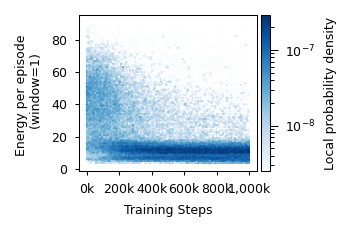

In [ ]:
# --- Scatter of per-episode ENERGY with local probability density coloring ---
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import numpy as np
import re


# GraphPad-style Matplotlib settings
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "pdf.use14corefonts": False,
    "svg.fonttype": "none",
})
pt_to_in = lambda pt: pt / 72

def moving_average(y, window):
    """Episode-based moving average aligned to the right (last point uses last 'window' episodes)."""
    if window <= 1:
        return np.asarray(y, dtype=float)
    if len(y) < window:
        return np.array([])  # not enough points
    k = np.ones(window, dtype=float) / window
    return np.convolve(np.asarray(y, dtype=float), k, mode="valid")

# --- Load TB scalars ---
ea = event_accumulator.EventAccumulator(run_dir, size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()
scalar_tags = set(ea.Tags().get("scalars", []))

env_tags = sorted(t for t in scalar_tags if re.fullmatch(r"env\d+/episode_return", t))
if not env_tags:
    raise RuntimeError("No 'env*/episode_return' tags found — did you enable PerEnvReturnAndLogCallback?")

# Parameters
WINDOW     = 1               # moving window size over episodes (use 1 for raw episodes)
MAX_POINTS = 250_0000         # downsample cap for plotting performance
BINS_XY    = (150, 150)      # bins for 2D density estimation (x,y)
DOT_SIZE   = 1.0             # scatter marker size
ALPHA      = 1.0              # scatter transparency

# Aggregate all (step, energy) pairs across envs 
all_steps = []
all_energy = []

for tag in env_tags:
    evs = ea.Scalars(tag)
    steps = np.asarray([e.step for e in evs], dtype=int)      # step where episode finished
    returns = np.asarray([e.value for e in evs], dtype=float) # episode return

    # Convert to ENERGY: E = 100 / return; ignore non-positive returns
    mask = returns > 0.0
    if not np.any(mask):
        continue
    steps = steps[mask]
    energies = 100.0 / returns[mask]

    # Moving window over energies; align x to window end
    e_ma = moving_average(energies, WINDOW)
    if e_ma.size == 0:
        continue
    x_ma = steps if WINDOW <= 1 else steps[WINDOW-1:]

    all_steps.append(x_ma)
    all_energy.append(e_ma)

if not all_steps:
    raise RuntimeError("No valid (step, energy) points to plot.")

X = np.concatenate(all_steps).astype(float)
Y = np.concatenate(all_energy).astype(float)

# Optional downsampling for speed
if X.size > MAX_POINTS:
    rng = np.random.default_rng(42)
    idx = rng.choice(X.size, size=MAX_POINTS, replace=False)
    X, Y = X[idx], Y[idx]

# --- Compute local probability density via 2D histogram ---
H, xedges, yedges = np.histogram2d(X, Y, bins=BINS_XY)
# Map each point to its bin count
xbin = np.searchsorted(xedges, X, side='right') - 1
ybin = np.searchsorted(yedges, Y, side='right') - 1
valid = (xbin >= 0) & (xbin < H.shape[0]) & (ybin >= 0) & (ybin < H.shape[1])
X, Y, xbin, ybin = X[valid], Y[valid], xbin[valid], ybin[valid]
counts = H[xbin, ybin].astype(float)

# Convert counts to probability density (normalize by total points and bin area)
dx = (xedges[1] - xedges[0])
dy = (yedges[1] - yedges[0])
bin_area = dx * dy if dx > 0 and dy > 0 else 1.0
density = counts / (X.size * bin_area)

# Normalize for coloring (log scale helps with heavy tails)
norm = mcolors.LogNorm(vmin=max(density.min(), 1e-12), vmax=density.max())

# --- Plot scatter colored by local density ---
fig, ax = plt.subplots(figsize=(pt_to_in(165), pt_to_in(110)), dpi=150)

sc = ax.scatter(X, Y, c=density, s=DOT_SIZE, linewidths=0, alpha = ALPHA, cmap="Blues", norm=norm, rasterized=True)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.02, fraction=0.1, aspect=18)
cbar.set_label("Local probability density", rotation=90)
cbar.ax.tick_params(which='major', direction='out', length=4.0, width=0.5, labelsize=6)
cbar.ax.tick_params(which='minor', direction='out', length=2.0, width=0.5)


# GraphPad aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.xaxis.set_major_locator(mticker.MultipleLocator(200_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

ax.set_xlabel("Training Steps")
ax.set_ylabel(f"Energy per episode \n (window={WINDOW})")

plt.tight_layout()

plt.savefig(Path(run_dir) /"training_energy_prob_density_graphpad_style.svg", format='svg', dpi = 300)

plt.show()


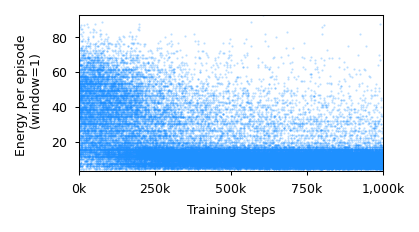

In [17]:
# --- Scatter of per-episode ENERGY (points only, no density) ---
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import numpy as np
import re
from pathlib import Path

# GraphPad-style Matplotlib settings
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "pdf.use14corefonts": False,
    "svg.fonttype": "none",
})
pt_to_in = lambda pt: pt / 72

def moving_average(y, window):
    """Episode-based moving average aligned to the right (last point uses last 'window' episodes)."""
    if window <= 1:
        return np.asarray(y, dtype=float)
    if len(y) < window:
        return np.array([])  # not enough points
    k = np.ones(window, dtype=float) / window
    return np.convolve(np.asarray(y, dtype=float), k, mode="valid")

# --- Load TB scalars ---
ea = event_accumulator.EventAccumulator(run_dir, size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()
scalar_tags = set(ea.Tags().get("scalars", []))

env_tags = sorted(t for t in scalar_tags if re.fullmatch(r"env\d+/episode_return", t))
if not env_tags:
    raise RuntimeError("No 'env*/episode_return' tags found — did you enable PerEnvReturnAndLogCallback?")

# Parameters
WINDOW     = 1               # moving window size over episodes (use 1 for raw episodes)
MAX_POINTS = 50_000       # downsample cap for plotting performance
DOT_SIZE   = 1.0             # scatter marker size
ALPHA      = 0.3            # scatter transparency
POINT_COLOR = "dodgerblue"        # single color for points (GraphPad-style)

# --- Aggregate all (step, energy) pairs across envs ---
all_steps = []
all_energy = []

for tag in env_tags:
    evs = ea.Scalars(tag)
    steps = np.asarray([e.step for e in evs], dtype=int)      # step where episode finished
    returns = np.asarray([e.value for e in evs], dtype=float) # episode return

    # Convert to ENERGY: E = 100 / return; ignore non-positive returns
    mask = returns > 0.0
    if not np.any(mask):
        continue
    steps = steps[mask]
    energies = 100.0 / returns[mask]

    # Moving window over energies; align x to window end
    e_ma = moving_average(energies, WINDOW)
    if e_ma.size == 0:
        continue
    x_ma = steps if WINDOW <= 1 else steps[WINDOW-1:]

    all_steps.append(x_ma)
    all_energy.append(e_ma)

if not all_steps:
    raise RuntimeError("No valid (step, energy) points to plot.")

X = np.concatenate(all_steps).astype(float)
Y = np.concatenate(all_energy).astype(float)

# Optional downsampling for speed
if X.size > MAX_POINTS:
    rng = np.random.default_rng(1)
    idx = rng.choice(X.size, size=MAX_POINTS, replace=False)
    X, Y = X[idx], Y[idx]

# --- Plot scatter (points only) ---
fig, ax = plt.subplots(figsize=(pt_to_in(200), pt_to_in(110)), dpi=150)

ax.scatter(X, Y, s=DOT_SIZE, linewidths=0, alpha=ALPHA, c=POINT_COLOR, rasterized=True)
ax.margins(x=0.0, y=0)
ax.set_xlim(left=0)

# GraphPad aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.xaxis.set_major_locator(mticker.MultipleLocator(250_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

ax.set_xlabel("Training Steps")
ax.set_ylabel(f"Energy per episode \n (window={WINDOW})")

plt.tight_layout()

out_path = Path(run_dir) / "training_energy_points_only_graphpad_style.svg"
plt.savefig(out_path, format="svg", dpi=300)
plt.show()


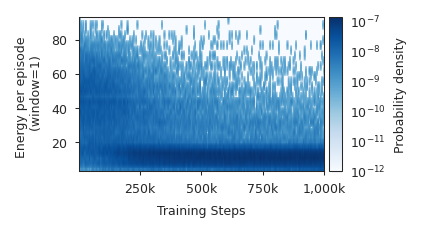

In [18]:
# --- ENERGY vs Steps with density heatmap (robust, rasterized) + optional points ---
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import seaborn as sns
import re
from pathlib import Path

# ===================== GraphPad-style (light) + seaborn theme =====================
sns.set_theme(context="paper", style="ticks")
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "pdf.use14corefonts": False,
    "svg.fonttype": "none",
})
pt_to_in = lambda pt: pt / 72

def moving_average(y, window):
    if window <= 1:
        return np.asarray(y, dtype=float)
    if len(y) < window:
        return np.array([])
    k = np.ones(window, dtype=float) / window
    return np.convolve(np.asarray(y, dtype=float), k, mode="valid")

# ===================== Parameters =====================
WINDOW          = 1                 # 1 = raw episodes
MAX_POINTS      = 2_500_000
BINS_XY         = (200, 30)        # 2D histogram resolution
COLOR_MAP       = "Blues"
OVERLAY_POINTS  = False
DOT_SIZE_PT2    = 2.0
ALPHA_POINTS    = 0.35
POINT_COLOR     = "black"

# Tiny positive floor to avoid log(0)
PDF_FLOOR       = 1e-12

# ===================== Load TB scalars =====================
# Define run_dir externally, e.g.: run_dir = "/path/to/tensorboard/run"
ea = event_accumulator.EventAccumulator(run_dir, size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()
scalar_tags = set(ea.Tags().get("scalars", []))

env_tags = sorted(t for t in scalar_tags if re.fullmatch(r"env\d+/episode_return", t))
if not env_tags:
    raise RuntimeError("No 'env*/episode_return' tags found — did you enable PerEnvReturnAndLogCallback?")

# Aggregate all (step, energy) pairs
all_steps, all_energy = [], []
for tag in env_tags:
    evs = ea.Scalars(tag)
    steps = np.asarray([e.step for e in evs], dtype=int)
    returns = np.asarray([e.value for e in evs], dtype=float)

    mask = returns > 0.0
    if not np.any(mask):
        continue
    steps = steps[mask]
    energies = 100.0 / returns[mask]

    e_ma = moving_average(energies, WINDOW)
    if e_ma.size == 0:
        continue
    x_ma = steps if WINDOW <= 1 else steps[WINDOW-1:]

    all_steps.append(x_ma)
    all_energy.append(e_ma)

if not all_steps:
    raise RuntimeError("No valid (step, energy) points to plot.")

X = np.concatenate(all_steps).astype(float)
Y = np.concatenate(all_energy).astype(float)

# Optional downsampling
if X.size > MAX_POINTS:
    rng = np.random.default_rng(42)
    idx = rng.choice(X.size, size=MAX_POINTS, replace=False)
    X, Y = X[idx], Y[idx]

# ===================== Build probability density grid (robust) =====================
# Handle degenerate ranges (constant X or Y)
x_min, x_max = float(np.min(X)), float(np.max(X))
y_min, y_max = float(np.min(Y)), float(np.max(Y))

# If range collapses, expand slightly so bins are valid
if not np.isfinite(x_min) or not np.isfinite(x_max) or x_min == x_max:
    x_min, x_max = x_min - 0.5, x_max + 0.5
if not np.isfinite(y_min) or not np.isfinite(y_max) or y_min == y_max:
    y_min, y_max = y_min - 0.5, y_max + 0.5

H, xedges, yedges = np.histogram2d(X, Y, bins=BINS_XY, range=[[x_min, x_max], [y_min, y_max]])

# Convert counts -> PDF over (x,y): sum(pdf * dx * dy) ~= 1
dx = (xedges[1] - xedges[0]) if len(xedges) > 1 else 1.0
dy = (yedges[1] - yedges[0]) if len(yedges) > 1 else 1.0
bin_area = max(dx * dy, PDF_FLOOR)

total = H.sum()
if total <= 0:
    # No data: create a tiny uniform field to keep the plot machinery happy
    pdf = np.full_like(H, PDF_FLOOR, dtype=float)
else:
    pdf = (H / total) / bin_area
    # Avoid zeros for log scaling
    pdf = np.maximum(pdf, PDF_FLOOR)

pdf_max = float(np.nanmax(pdf))
use_log = np.isfinite(pdf_max) and pdf_max > PDF_FLOOR * 1.001

if use_log:
    norm = LogNorm(vmin=PDF_FLOOR, vmax=pdf_max)
else:
    # Fall back to linear if everything is essentially the floor
    norm = Normalize(vmin=PDF_FLOOR, vmax=max(pdf_max, PDF_FLOOR * 2.0))

# ===================== Plot =====================
fig, ax = plt.subplots(figsize=(pt_to_in(200), pt_to_in(110)), dpi=150)

# Heatmap via imshow (no pcolormesh seams), rasterized to avoid hairlines in vector outputs
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(
    pdf.T,
    origin="lower",
    extent=extent,
    aspect="auto",
    cmap=COLOR_MAP,
    norm=norm,
    interpolation="bilinear",
    zorder=0,
)
im.set_rasterized(True)

cbar = plt.colorbar(im, ax=ax, pad=0.02, fraction=0.08, aspect=12)
cbar.set_label("Probability density")

# Optional: overlay points
if OVERLAY_POINTS:
    ax.scatter(
        X, Y,
        s=DOT_SIZE_PT2,
        c=POINT_COLOR,
        alpha=ALPHA_POINTS,
        linewidths=0,
        rasterized=True,
        zorder=1
    )

# Aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.xaxis.set_major_locator(mticker.MultipleLocator(250_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

ax.set_xlabel("Training Steps")
ax.set_ylabel(f"Energy per episode \n (window={WINDOW})")

plt.tight_layout()
out_name = "training_energy_density_heatmap_rasterized.svg"
plt.savefig(Path(run_dir) / out_name, format="svg", dpi=300)
plt.show()


Evaluations

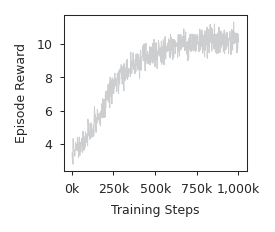

In [19]:
# --- Imports & GraphPad-style formatting ---
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import numpy as np


mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,          # keep text editable in vector outputs
    "ps.fonttype": 42,
    "pdf.use14corefonts": False,
    "svg.fonttype": "none",
})
pt_to_in = lambda pt: pt / 72

# --- Load scalars ---
ea = event_accumulator.EventAccumulator(run_dir, size_guidance={event_accumulator.SCALARS: 0})
ea.Reload()
scalar_tags = set(ea.Tags().get("scalars", []))

train = ea.Scalars("rollout/ep_rew_mean") if "rollout/ep_rew_mean" in scalar_tags else []
eval_  = ea.Scalars("eval/mean_reward")    if "eval/mean_reward"    in scalar_tags else []

t_x, t_y = ([], [])
e_x, e_y = ([], [])
if train:
    t_x = [e.step for e in train]
    t_y = [e.value for e in train]
if eval_:
    e_x = [e.step for e in eval_]
    e_y = [e.value for e in eval_]

# Plot 
fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)

# training curve
if t_x:
    ax.plot(t_x, t_y, label="Training mean reward",
            color="#CDCED0", zorder=1)

# evaluation points (bring to the front)
if e_x:
    ax.scatter(e_x, e_y, label="Evaluation mean reward",
               facecolors="none", edgecolors="#417FF1",
               s=4, linewidth=0.75, zorder=3)

# GraphPad aesthetics
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
ax.xaxis.set_major_locator(mticker.MultipleLocator(250_000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

ax.set_xlabel("Training Steps")
ax.set_ylabel("Episode Reward")
#ax.legend(loc="best")

plt.tight_layout()


plt.savefig(Path(run_dir) /"training_reward_and_evaluation_graphpad_style.svg", format='svg', dpi = 300)

plt.show()

Minimum energy


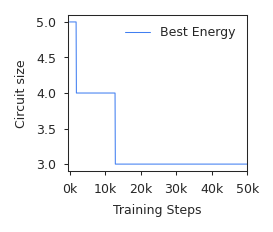

In [20]:
# --- Imports & GraphPad-style formatting ---
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import numpy as np

# (Assumes `ea` is already created via EventAccumulator and Reloaded in a previous cell)

# GraphPad-style Matplotlib settings (same as before)
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 6,
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "axes.linewidth": 0.5,
    "lines.linewidth": 0.5,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "legend.fontsize": 6,
    "legend.frameon": False,
    "savefig.dpi": 300,
    "figure.dpi": 100,
    "figure.figsize": (8, 4),
    "axes.grid": False,
    "pdf.fonttype": 42,          # keep text editable in vector outputs
    "ps.fonttype": 42,
    "pdf.use14corefonts": False,
    "svg.fonttype": "none",
})
pt_to_in = lambda pt: pt / 72

# --- Plot custom/best_energy ---
tag = "custom/best_energy"

if tag in (ea.Tags().get("scalars", []) or []):
    events = ea.Scalars(tag)
    if events:
        steps  = np.fromiter((e.step  for e in events), dtype=int)
        best_E = np.fromiter((e.value for e in events), dtype=float)

        # Re-zero x-axis to start at 0
        steps = steps - steps[0]

        fig, ax = plt.subplots(figsize=(pt_to_in(130), pt_to_in(110)), dpi=150)
        ax.plot(steps, best_E, color="#417FF1", label="Best Energy")

        # GraphPad aesthetics
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
        ax.xaxis.set_major_locator(mticker.MultipleLocator(10_000))
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000):,}k"))
        ax.tick_params(axis='both', which='both', direction='out', length=2, width=0.5)

        ax.set_xlim(left=-500, right=50000)
        ax.set_xlabel("Training Steps")
        ax.set_ylabel("Circuit size")  # or "Best Energy", depending on your meaning
        ax.legend(loc="best")

        plt.tight_layout()
        plt.show()
    else:
        print(f"Tag '{tag}' found but contains no scalar events.")
else:
    print(f"Scalar tag '{tag}' not found in this run.")


In [21]:
print(ea.Tags())

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['custom/best_energy', 'env0/episode_return', 'env0/episode_return_disc', 'env1/episode_return', 'env1/episode_return_disc', 'env10/episode_return', 'env10/episode_return_disc', 'env11/episode_return', 'env11/episode_return_disc', 'env12/episode_return', 'env12/episode_return_disc', 'env13/episode_return', 'env13/episode_return_disc', 'env14/episode_return', 'env14/episode_return_disc', 'env15/episode_return', 'env15/episode_return_disc', 'env16/episode_return', 'env16/episode_return_disc', 'env17/episode_return', 'env17/episode_return_disc', 'env18/episode_return', 'env18/episode_return_disc', 'env19/episode_return', 'env19/episode_return_disc', 'env2/episode_return', 'env2/episode_return_disc', 'env20/episode_return', 'env20/episode_return_disc', 'env21/episode_return', 'env21/episode_return_disc', 'env22/episode_return', 'env22/episode_return_disc', 'env23/episode_return', 'env23/episode_return_disc', 'env24/episode_return', '

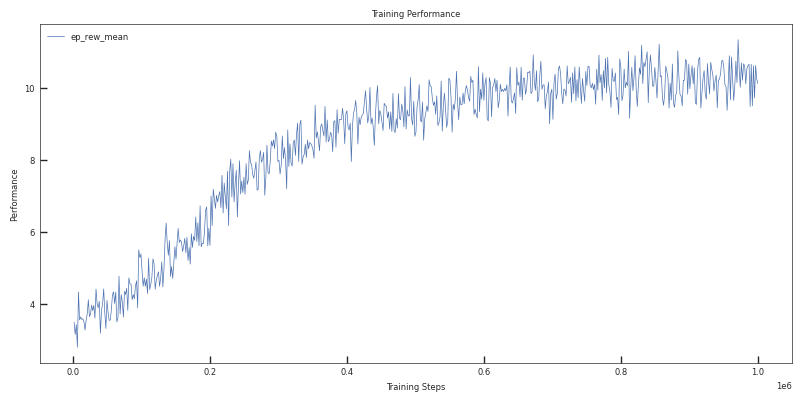

In [22]:
for tag in ['rollout/ep_rew_mean']:
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    plt.plot(steps, values, label=tag.split('/')[-1])

plt.xlabel("Training Steps")
plt.ylabel("Performance")
plt.title("Training Performance")
plt.legend()
plt.tight_layout()
plt.show()


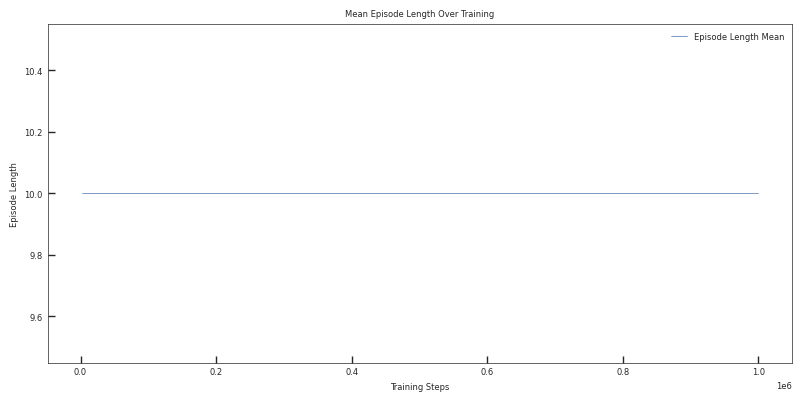

In [23]:
tag = 'rollout/ep_len_mean'
events = ea.Scalars(tag)
steps = [e.step for e in events]
values = [e.value for e in events]

plt.plot(steps, values, label='Episode Length Mean')
plt.xlabel("Training Steps")
plt.ylabel("Episode Length")
plt.title("Mean Episode Length Over Training")
plt.legend()
plt.tight_layout()
plt.show()

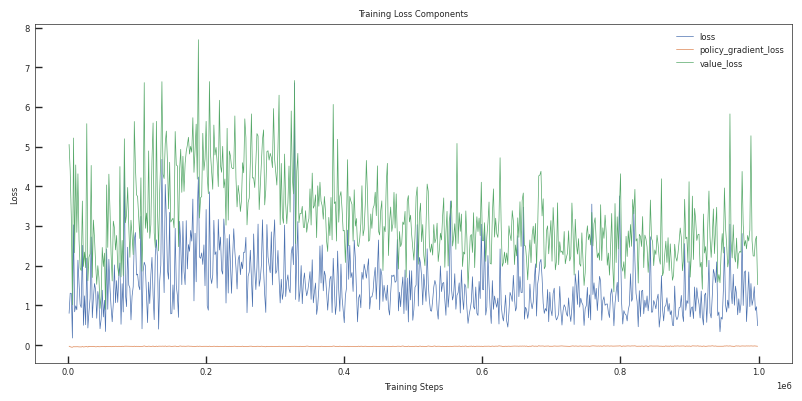

In [24]:
for tag in ['train/loss', 'train/policy_gradient_loss', 'train/value_loss']:
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    plt.plot(steps, values, label=tag.split('/')[-1])

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Components")
plt.legend()
plt.tight_layout()
plt.show()


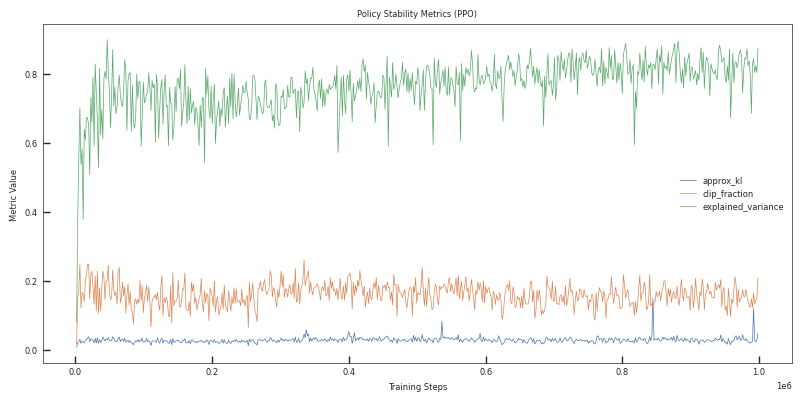

In [25]:
for tag in ['train/approx_kl', 'train/clip_fraction', 'train/explained_variance']:
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    plt.plot(steps, values, label=tag.split('/')[-1])

plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.title("Policy Stability Metrics (PPO)")
plt.legend()
plt.tight_layout()
plt.show()

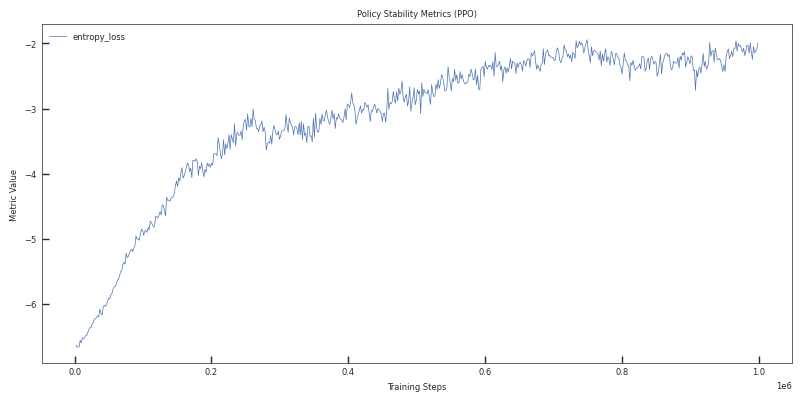

In [26]:
for tag in ['train/entropy_loss']:
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    plt.plot(steps, values, label=tag.split('/')[-1])

plt.xlabel("Training Steps")
plt.ylabel("Metric Value")
plt.title("Policy Stability Metrics (PPO)")
plt.legend()
plt.tight_layout()
plt.show()

Sanity check to make sure the mean across environments from the callbacks is equivalent to the TensorBoard calculation of mean reward

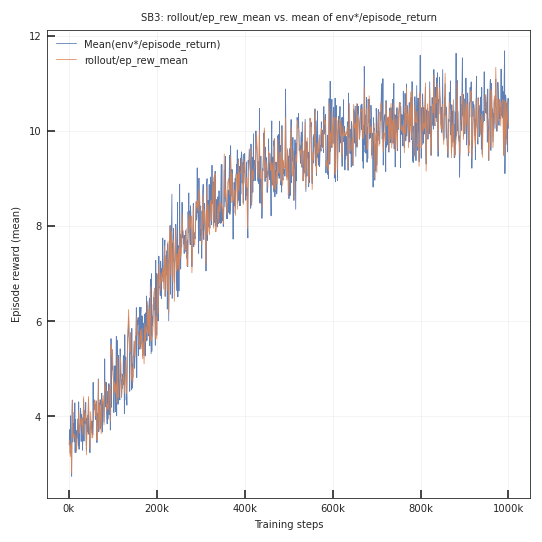

In [27]:
from pathlib import Path
import re
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tensorboard.backend.event_processing import event_accumulator

# ---------- CONFIG ----------
RUN_DIR = run_dir

# Optional smoothing for noisy curves (EMA)
def smooth_ema(y, weight=0.0):
    if len(y) == 0:
        return y
    out = []
    last = y[0]
    for v in y:
        last = weight * last + (1 - weight) * v
        out.append(last)
    return out

# ---------- LOAD ----------
ea = event_accumulator.EventAccumulator(
    RUN_DIR,
    size_guidance={
        # Load everything (can downscale these if logs are huge)
        event_accumulator.SCALARS: 0,
        event_accumulator.TENSORS: 0,
        event_accumulator.HISTOGRAMS: 0,
        event_accumulator.COMPRESSED_HISTOGRAMS: 0,
        event_accumulator.IMAGES: 0,
        event_accumulator.AUDIO: 0,
    },
)
ea.Reload()

scalar_tags = set(ea.Tags().get("scalars", []))

# ---------- 1) rollout/ep_rew_mean ----------
rollout_steps, rollout_values = [], []
if "rollout/ep_rew_mean" in scalar_tags:
    for ev in ea.Scalars("rollout/ep_rew_mean"):
        rollout_steps.append(ev.step)
        rollout_values.append(ev.value)
else:
    print("Warning: 'rollout/ep_rew_mean' not found in this run.")

# ---------- 2) env*/episode_return (mean across envs per dump step) ----------
# Find all tags that look like "env123/episode_return" (NOT discounted)
env_tag_pattern = re.compile(r"^env\d+/episode_return$")
env_tags = sorted([t for t in scalar_tags if env_tag_pattern.match(t)])

if not env_tags:
    print("Warning: no 'env*/episode_return' tags found.")

# Collect env returns grouped by their TensorBoard step
# (Each env tag yields many (step, value) points. We mean across envs per 'step'.)
step_to_env_vals = defaultdict(list)
for tag in env_tags:
    for ev in ea.Scalars(tag):
        step_to_env_vals[ev.step].append(ev.value)

env_mean_steps = sorted(step_to_env_vals.keys())
env_mean_values = [float(np.mean(step_to_env_vals[s])) for s in env_mean_steps]

# ---------- (Optional) smoothing ----------
# rollout_values_smooth = smooth_ema(rollout_values, weight=0.90)
# env_mean_values_smooth = smooth_ema(env_mean_values, weight=0.90)

# ---------- PLOT ----------
plt.figure(figsize=(4.5, 4.5), dpi=120)

# Plot the mean across env*/episode_return
plt.plot(env_mean_steps, env_mean_values, label="Mean(env*/episode_return)", alpha=0.9)

# Plot rollout/ep_rew_mean (SB3)
plt.plot(rollout_steps, rollout_values, label="rollout/ep_rew_mean", alpha=0.9)

plt.xlabel("Training steps")
plt.ylabel("Episode reward (mean)")
plt.title("SB3: rollout/ep_rew_mean vs. mean of env*/episode_return")

# Nice x-axis formatting (k = thousands)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))
plt.grid(True, alpha=0.2, linewidth=0.6)
plt.legend()
plt.tight_layout()
plt.show()
